## 라이브러리 설치


In [3]:
!pip install palmerpenguins seaborn scikit-learn xgboost -q

## 빅데이터 관련 라이브러리 임포트

In [4]:
# 데이터 처리
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, classification_report

# 모델들
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

print("✅ 라이브러리 임포트 완료!")

✅ 라이브러리 임포트 완료!


## 시각화 설정

폰트 및 그리드 스타일 설정

In [5]:
# 한글 폰트 및 스타일 설정
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style('whitegrid')
sns.set_palette('husl')

## 데이터로드

이번에는 palmerpenguins api를 이용하겠습니다.

In [6]:
from palmerpenguins import load_penguins

# 데이터 로드
penguins = load_penguins()
print(f"📊 데이터 크기: {penguins.shape}")
print(f"🐧 펭귄 수: {penguins.shape[0]}마리")
print(f"📝 변수 수: {penguins.shape[1]}개")

📊 데이터 크기: (344, 8)
🐧 펭귄 수: 344마리
📝 변수 수: 8개


## 데이터 이해 및 구조확인

In [7]:
# 첫 5행 확인
penguins.head()

# 데이터 타입 확인
penguins.info()

# 기초 통계량
penguins.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
 7   year               344 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 21.6+ KB


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
count,342.000000,342.000000,342.000000,342.000000,344.000000
mean,43.921930,17.151170,200.915205,4201.754386,2008.029070
std,5.459584,1.974793,14.061714,801.954536,0.818356
min,32.100000,13.100000,172.000000,2700.000000,2007.000000
25%,39.225000,15.600000,190.000000,3550.000000,2007.000000
50%,44.450000,17.300000,197.000000,4050.000000,2008.000000
75%,48.500000,18.700000,213.000000,4750.000000,2009.000000
max,59.600000,21.500000,231.000000,6300.000000,2009.000000


🐧 펭귄 종별 분포:
species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

📊 클래스 불균형 비율: 2.24


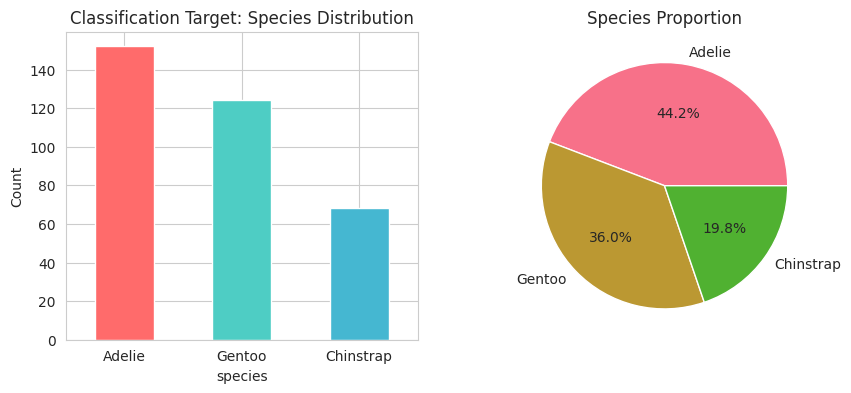

In [8]:
# 종별 분포 확인
species_counts = penguins['species'].value_counts()
print("🐧 펭귄 종별 분포:")
print(species_counts)
print(f"\n📊 클래스 불균형 비율: {species_counts.max() / species_counts.min():.2f}")

# 시각화
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
species_counts.plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.title('Classification Target: Species Distribution')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
species_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Species Proportion')
plt.ylabel('')
plt.show()

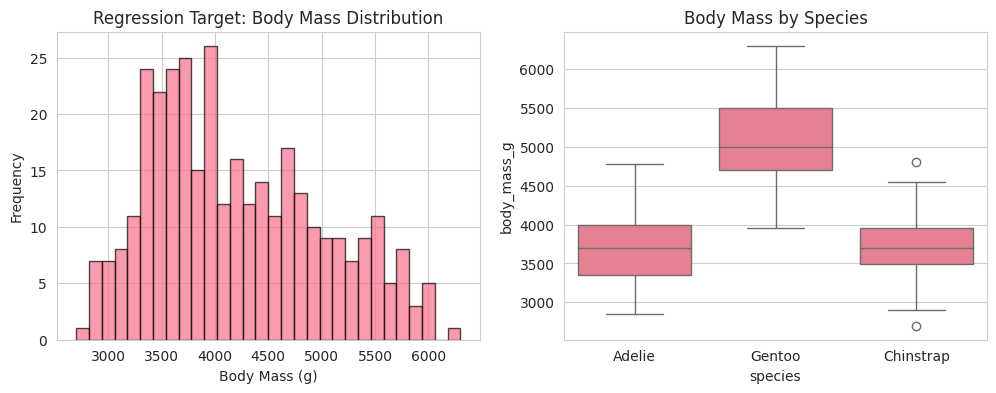

📊 몸무게 통계:
평균: 4202g
표준편차: 802g
최소/최대: 2700g / 6300g


In [10]:
# 몸무게 분포 확인
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(penguins['body_mass_g'].dropna(), bins=30, edgecolor='black', alpha=0.7)
plt.title('Regression Target: Body Mass Distribution')
plt.xlabel('Body Mass (g)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(data=penguins, x='species', y='body_mass_g')
plt.title('Body Mass by Species')
plt.show()

print(f"📊 몸무게 통계:")
print(f"평균: {penguins['body_mass_g'].mean():.0f}g")
print(f"표준편차: {penguins['body_mass_g'].std():.0f}g")
print(f"최소/최대: {penguins['body_mass_g'].min():.0f}g / {penguins['body_mass_g'].max():.0f}g")

## 여기까지 확인했을때, 종별로 뚜렸하게 구분되는 무게 변화가 있다.

## 전처리

In [11]:
# 결측치 확인
missing_values = penguins.isna().sum()
missing_percent = (missing_values / len(penguins) * 100).round(2)

print("🔍 결측치 현황:")
for col, pct in missing_percent[missing_percent > 0].items():
    print(f"  {col}: {missing_values[col]}개 ({pct}%)")

# 결측치 처리 전략
print("\n📌 처리 전략:")
print("1. sex: 가장 빈번한 값으로 대체 (mode imputation)")
print("2. 측정값: 종별 평균으로 대체 (mean imputation)")
print("3. 또는 간단히: 결측치 있는 행 제거 (오늘 선택)")

# 결측치 제거
penguins_clean = penguins.dropna()
print(f"\n✅ 처리 후: {len(penguins_clean)}개 샘플 (제거: {len(penguins) - len(penguins_clean)}개)")

🔍 결측치 현황:
  bill_length_mm: 2개 (0.58%)
  bill_depth_mm: 2개 (0.58%)
  flipper_length_mm: 2개 (0.58%)
  body_mass_g: 2개 (0.58%)
  sex: 11개 (3.2%)

📌 처리 전략:
1. sex: 가장 빈번한 값으로 대체 (mode imputation)
2. 측정값: 종별 평균으로 대체 (mean imputation)
3. 또는 간단히: 결측치 있는 행 제거 (오늘 선택)

✅ 처리 후: 333개 샘플 (제거: 11개)


## 특성 상관성 분석

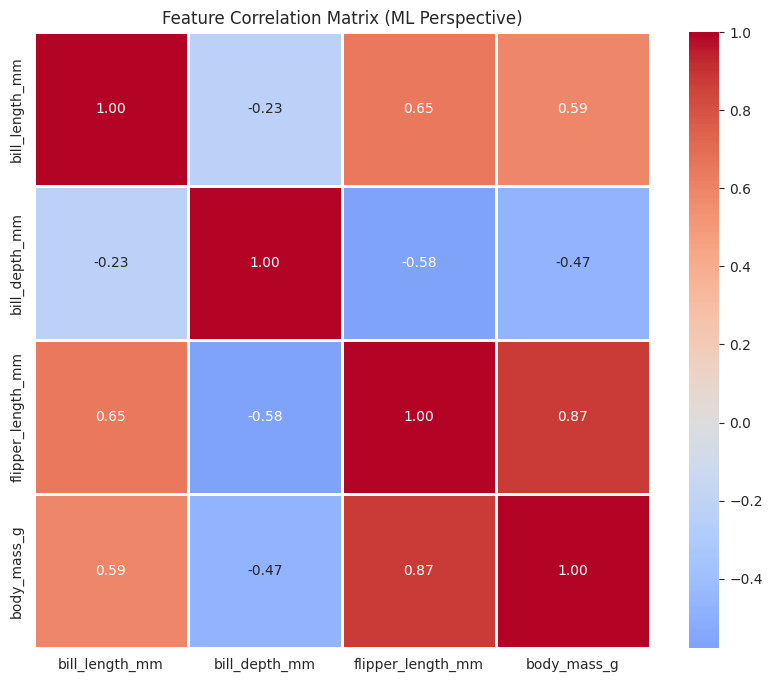

🔑 머신러닝 관점 인사이트:
1. flipper_length와 body_mass 높은 상관관계 (0.87) → 다중공선성 주의
2. bill_length와 bill_depth 음의 상관관계 (-0.24) → 흥미로운 패턴
3. 모든 특성이 어느 정도 독립적 → 좋은 신호!


In [12]:
# 수치형 변수만 선택
numerical_features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

# 상관관계 매트릭스
correlation_matrix = penguins_clean[numerical_features].corr()

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Feature Correlation Matrix (ML Perspective)')
plt.show()



🔑 머신러닝 관점 인사이트:
1. flipper_length와 body_mass 높은 상관관계 (0.87) → 다중공선성 주의"
2. bill_length와 bill_depth 음의 상관관계 (-0.24) → 흥미로운 패턴"
3. 모든 특성이 어느 정도 독립적 → 좋은 신호!"


## Feature Engineering

In [13]:
# 1. 비율 특성 생성
penguins_clean['bill_ratio'] = penguins_clean['bill_length_mm'] / penguins_clean['bill_depth_mm']
penguins_clean['bill_area'] = penguins_clean['bill_length_mm'] * penguins_clean['bill_depth_mm']

# 2. BMI 유사 지표
penguins_clean['body_mass_per_flipper'] = penguins_clean['body_mass_g'] / penguins_clean['flipper_length_mm']
penguins_clean['penguin_bmi'] = penguins_clean['body_mass_g'] / (penguins_clean['flipper_length_mm'] ** 2) * 10000

# 3. 크기 카테고리 (회귀용)
penguins_clean['size_category'] = pd.cut(penguins_clean['body_mass_g'],
                                          bins=[0, 3500, 4500, 7000],
                                          labels=['Small', 'Medium', 'Large'])

# 4. 성별 인코딩
penguins_clean['sex_encoded'] = penguins_clean['sex'].map({'male': 1, 'female': 0})

# 5. 섬 원핫 인코딩
island_dummies = pd.get_dummies(penguins_clean['island'], prefix='island')
penguins_clean = pd.concat([penguins_clean, island_dummies], axis=1)

print("✨ 새로운 특성 생성 완료!")
print(f"원래 특성 수: 8개")
print(f"현재 특성 수: {len(penguins_clean.columns)}개")
print("\n새로 생성된 특성들:")
new_features = ['bill_ratio', 'bill_area', 'body_mass_per_flipper', 'penguin_bmi',
                'size_category', 'sex_encoded', 'island_Biscoe', 'island_Dream', 'island_Torgersen']
for feat in new_features:
    if feat in penguins_clean.columns:
        print(f"  ✓ {feat}")

✨ 새로운 특성 생성 완료!
원래 특성 수: 8개
현재 특성 수: 17개

새로 생성된 특성들:
  ✓ bill_ratio
  ✓ bill_area
  ✓ body_mass_per_flipper
  ✓ penguin_bmi
  ✓ size_category
  ✓ sex_encoded
  ✓ island_Biscoe
  ✓ island_Dream
  ✓ island_Torgersen


## 데이터 준비

In [15]:
# 특성과 타겟 분리
feature_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
X = penguins_clean[feature_cols]
y = penguins_clean['species']

# 레이블 인코딩
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("🏷️ 레이블 인코딩:")
for i, species in enumerate(le.classes_):
    print(f"  {species} → {i}")

# Train-Test 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\n📊 데이터 분할:")
print(f"  학습 세트: {X_train.shape[0]} 샘플")
print(f"  테스트 세트: {X_test.shape[0]} 샘플")
print(f"  비율: {X_train.shape[0]/len(X):.1%} / {X_test.shape[0]/len(X):.1%}")

# Stratify 확인
print(f"\n✅ Stratified Split 확인:")
print(f"  원본 종 비율: {np.bincount(y_encoded) / len(y_encoded)}")
print(f"  학습 종 비율: {np.bincount(y_train) / len(y_train)}")
print(f"  테스트 종 비율: {np.bincount(y_test) / len(y_test)}")

🏷️ 레이블 인코딩:
  Adelie → 0
  Chinstrap → 1
  Gentoo → 2

📊 데이터 분할:
  학습 세트: 266 샘플
  테스트 세트: 67 샘플
  비율: 79.9% / 20.1%

✅ Stratified Split 확인:
  원본 종 비율: [0.43843844 0.2042042  0.35735736]
  학습 종 비율: [0.43984962 0.20300752 0.35714286]
  테스트 종 비율: [0.43283582 0.20895522 0.35820896]


## 데이터 스케일링

In [16]:
# StandardScaler 적용
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # fit하지 않고 transform만!

print("📏 스케일링 전후 비교:")
print(f"  원본 평균: {X_train.mean().mean():.2f}")
print(f"  원본 표준편차: {X_train.std().mean():.2f}")
print(f"  스케일링 후 평균: {X_train_scaled.mean():.2e}")
print(f"  스케일링 후 표준편차: {X_train_scaled.std():.2f}")

# 주의사항
print("\n⚠️ 중요: scaler.fit()은 train 데이터에만 적용!")
print("테스트 데이터는 transform()만 사용 → 데이터 누출 방지")

📏 스케일링 전후 비교:
  원본 평균: 1121.74
  원본 표준편차: 207.98
  스케일링 후 평균: -2.75e-17
  스케일링 후 표준편차: 1.00

⚠️ 중요: scaler.fit()은 train 데이터에만 적용!
테스트 데이터는 transform()만 사용 → 데이터 누출 방지


## 분류모델 학습

In [17]:
# 모델 정의
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# 결과 저장
results = {}

print("🚀 모델 학습 시작...\n")
for name, model in models.items():
    # 학습
    model.fit(X_train_scaled, y_train)

    # 예측
    y_pred = model.predict(X_test_scaled)

    # 평가
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'accuracy': accuracy
    }

    print(f"✅ {name:20s} - Accuracy: {accuracy:.4f}")

# 최고 성능 모델
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
print(f"\n🏆 최고 성능 모델: {best_model_name} ({results[best_model_name]['accuracy']:.4f})")

🚀 모델 학습 시작...

✅ Logistic Regression  - Accuracy: 1.0000
✅ Decision Tree        - Accuracy: 0.9552
✅ Random Forest        - Accuracy: 0.9701
✅ SVM                  - Accuracy: 1.0000
✅ KNN                  - Accuracy: 1.0000

🏆 최고 성능 모델: Logistic Regression (1.0000)


## 혼동행렬

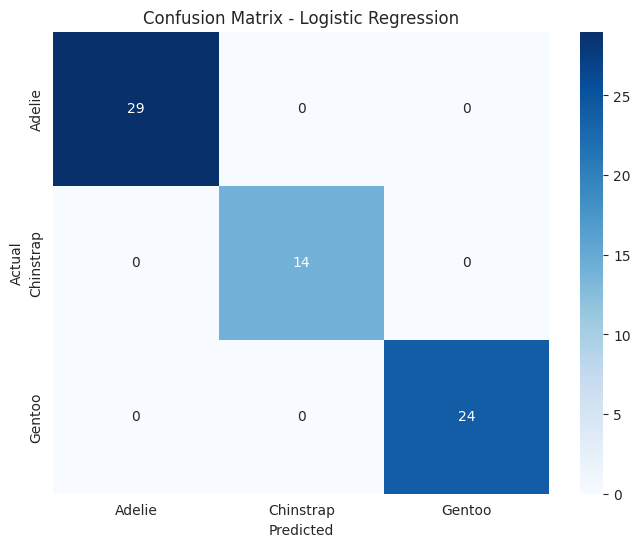

📊 혼동 행렬 해석:
  정확히 예측한 샘플: 67개
  잘못 예측한 샘플: 0개
  Adelie: 29/29 정확
  Chinstrap: 14/14 정확
  Gentoo: 24/24 정확


In [18]:
# 최고 성능 모델의 혼동 행렬
best_model = results[best_model_name]['model']
y_pred_best = results[best_model_name]['predictions']

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred_best)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("📊 혼동 행렬 해석:")
print(f"  정확히 예측한 샘플: {np.diag(cm).sum()}개")
print(f"  잘못 예측한 샘플: {cm.sum() - np.diag(cm).sum()}개")
for i, species in enumerate(le.classes_):
    print(f"  {species}: {cm[i,i]}/{cm[i].sum()} 정확")

## Classification Report

In [19]:
# 상세 평가 지표
print(f"\n📈 {best_model_name} 상세 평가:\n")
print(classification_report(y_test, y_pred_best, target_names=le.classes_))

# Precision, Recall, F1-score 설명
print("\n📚 평가 지표 설명:")
print("""
- Precision (정밀도): 예측한 것 중 실제 맞은 비율
  → "내가 A라고 한 것 중 진짜 A인 비율"

- Recall (재현율): 실제 중에서 맞게 예측한 비율
  → "진짜 A 중에서 내가 A라고 맞춘 비율"

- F1-score: Precision과 Recall의 조화평균
  → 둘 다 고려한 종합 점수

- Support: 각 클래스의 실제 샘플 수
""")


📈 Logistic Regression 상세 평가:

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        29
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        24

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67


📚 평가 지표 설명:

- Precision (정밀도): 예측한 것 중 실제 맞은 비율
  → "내가 A라고 한 것 중 진짜 A인 비율"
  
- Recall (재현율): 실제 중에서 맞게 예측한 비율
  → "진짜 A 중에서 내가 A라고 맞춘 비율"
  
- F1-score: Precision과 Recall의 조화평균
  → 둘 다 고려한 종합 점수
  
- Support: 각 클래스의 실제 샘플 수



##  회귀 모델링


In [20]:
print("🎯 회귀 문제: 펭귄 몸무게 예측\n")

# 특성과 타겟
X_reg = penguins_clean[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']]
y_reg = penguins_clean['body_mass_g']

# 추가 특성 포함 버전
X_reg_extended = penguins_clean[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm',
                                  'bill_ratio', 'bill_area', 'sex_encoded',
                                  'island_Biscoe', 'island_Dream']]

print(f"📊 데이터 정보:")
print(f"  기본 특성: {X_reg.shape[1]}개")
print(f"  확장 특성: {X_reg_extended.shape[1]}개")
print(f"  타겟 범위: {y_reg.min():.0f}g ~ {y_reg.max():.0f}g")
print(f"  타겟 평균: {y_reg.mean():.0f}g (±{y_reg.std():.0f}g)")

# Train-Test Split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg_extended, y_reg, test_size=0.2, random_state=42
)

# 스케일링
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

print(f"\n✅ 회귀 데이터 준비 완료!")

🎯 회귀 문제: 펭귄 몸무게 예측

📊 데이터 정보:
  기본 특성: 3개
  확장 특성: 8개
  타겟 범위: 2700g ~ 6300g
  타겟 평균: 4207g (±805g)

✅ 회귀 데이터 준비 완료!


In [21]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 회귀 모델들
regression_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# 결과 저장
regression_results = {}

print("🚀 회귀 모델 학습 시작...\n")
for name, model in regression_models.items():
    # 학습
    model.fit(X_train_reg_scaled, y_train_reg)

    # 예측
    y_pred = model.predict(X_test_reg_scaled)

    # 평가
    mse = mean_squared_error(y_test_reg, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_reg, y_pred)

    regression_results[name] = {
        'model': model,
        'predictions': y_pred,
        'rmse': rmse,
        'mae': mae,
    }

    print(f"{name:20s}")
    print(f"  RMSE: {rmse:.2f}g")
    print(f"  MAE: {mae:.2f}g\n")

# 최고 성능 모델 (R² 기준)
best_reg_model = max(regression_results, key=lambda x: regression_results[x]['r2'])
print(f"🏆 최고 R² 모델: {best_reg_model} ({regression_results[best_reg_model]['r2']:.4f})")

🚀 회귀 모델 학습 시작...

Linear Regression   
  R² Score: 0.8674
  RMSE: 281.59g
  MAE: 221.51g

Ridge Regression    
  R² Score: 0.8564
  RMSE: 293.00g
  MAE: 237.11g

Lasso Regression    
  R² Score: 0.8587
  RMSE: 290.62g
  MAE: 234.46g

Random Forest       
  R² Score: 0.8369
  RMSE: 312.22g
  MAE: 245.94g

Gradient Boosting   
  R² Score: 0.8364
  RMSE: 312.74g
  MAE: 241.28g

🏆 최고 R² 모델: Linear Regression (0.8674)


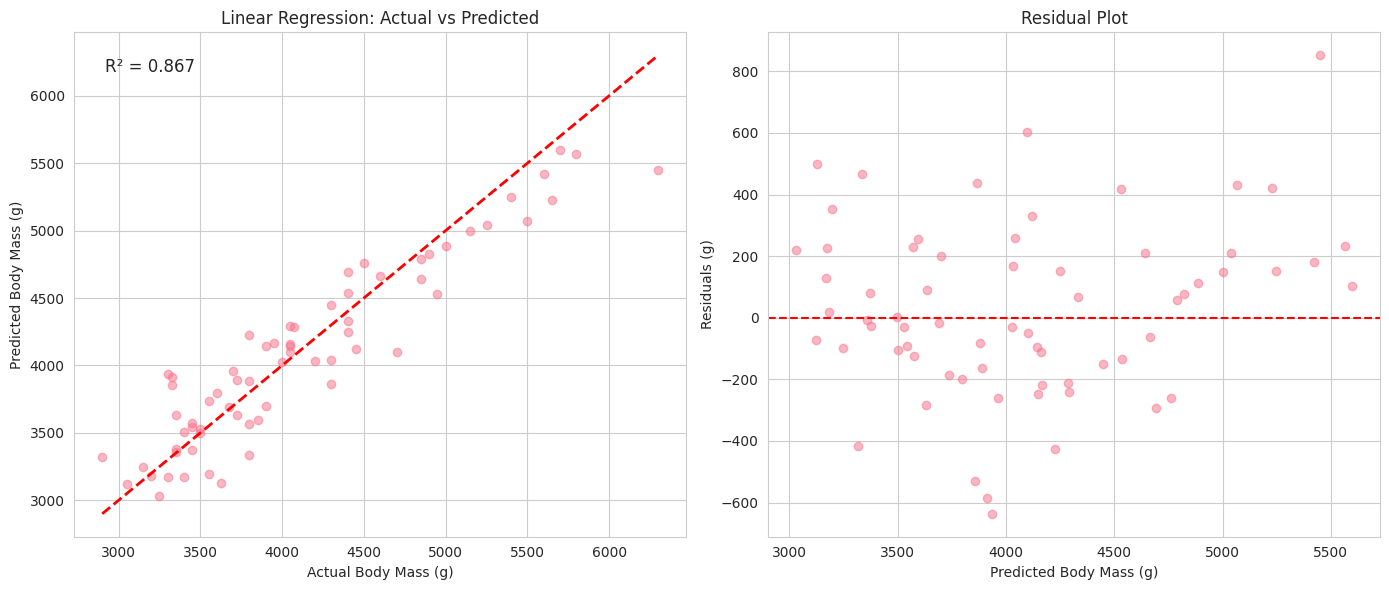

📊 잔차 분석:
  평균 잔차: 29.14g (0에 가까울수록 좋음)
  잔차 표준편차: 282.19g


In [22]:
# 최고 모델의 예측 결과
best_reg_pred = regression_results[best_reg_model]['predictions']

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot
axes[0].scatter(y_test_reg, best_reg_pred, alpha=0.5)
axes[0].plot([y_test_reg.min(), y_test_reg.max()],
             [y_test_reg.min(), y_test_reg.max()],
             'r--', lw=2)
axes[0].set_xlabel('Actual Body Mass (g)')
axes[0].set_ylabel('Predicted Body Mass (g)')
axes[0].set_title(f'{best_reg_model}: Actual vs Predicted')
axes[0].text(0.05, 0.95, f'R² = {regression_results[best_reg_model]["r2"]:.3f}',
             transform=axes[0].transAxes, fontsize=12, verticalalignment='top')

# Residual plot
residuals = y_test_reg - best_reg_pred
axes[1].scatter(best_reg_pred, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Body Mass (g)')
axes[1].set_ylabel('Residuals (g)')
axes[1].set_title('Residual Plot')

plt.tight_layout()
plt.show()

print("📊 잔차 분석:")
print(f"  평균 잔차: {residuals.mean():.2f}g (0에 가까울수록 좋음)")
print(f"  잔차 표준편차: {residuals.std():.2f}g")
if abs(residuals.mean()) < 10:
    print("  ✅ 모델이 편향되지 않음 (unbiased)")

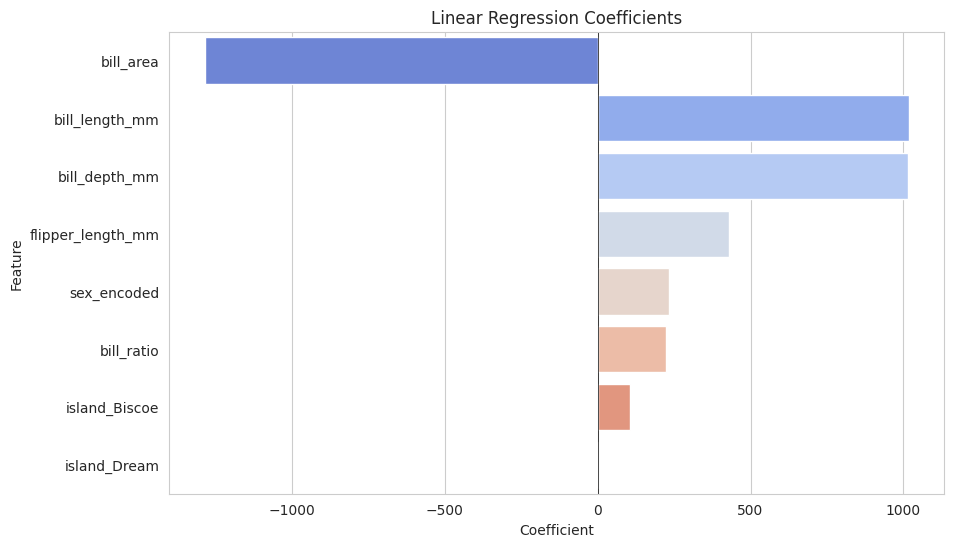

📈 선형 회귀 계수 해석:
  bill_area: -1286.52
    → 1 단위 증가 시 몸무게 1287g 감소
  bill_length_mm: 1018.74
    → 1 단위 증가 시 몸무게 1019g 증가
  bill_depth_mm: 1016.02
    → 1 단위 증가 시 몸무게 1016g 증가


In [23]:
# Linear Regression 계수
if 'Linear Regression' in regression_results:
    lr_model = regression_results['Linear Regression']['model']

    coefficients = pd.DataFrame({
        'Feature': X_reg_extended.columns,
        'Coefficient': lr_model.coef_
    }).sort_values('Coefficient', key=abs, ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=coefficients, x='Coefficient', y='Feature', palette='coolwarm')
    plt.title('Linear Regression Coefficients')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.show()

    print("📈 선형 회귀 계수 해석:")
    for _, row in coefficients.head(3).iterrows():
        print(f"  {row['Feature']}: {row['Coefficient']:.2f}")
        if row['Coefficient'] > 0:
            print(f"    → 1 단위 증가 시 몸무게 {abs(row['Coefficient']):.0f}g 증가")
        else:
            print(f"    → 1 단위 증가 시 몸무게 {abs(row['Coefficient']):.0f}g 감소")

## 클러스터링과 차원 축소

## K-Means 클러스터링

🎯 비지도학습: 정답 없이 패턴 찾기



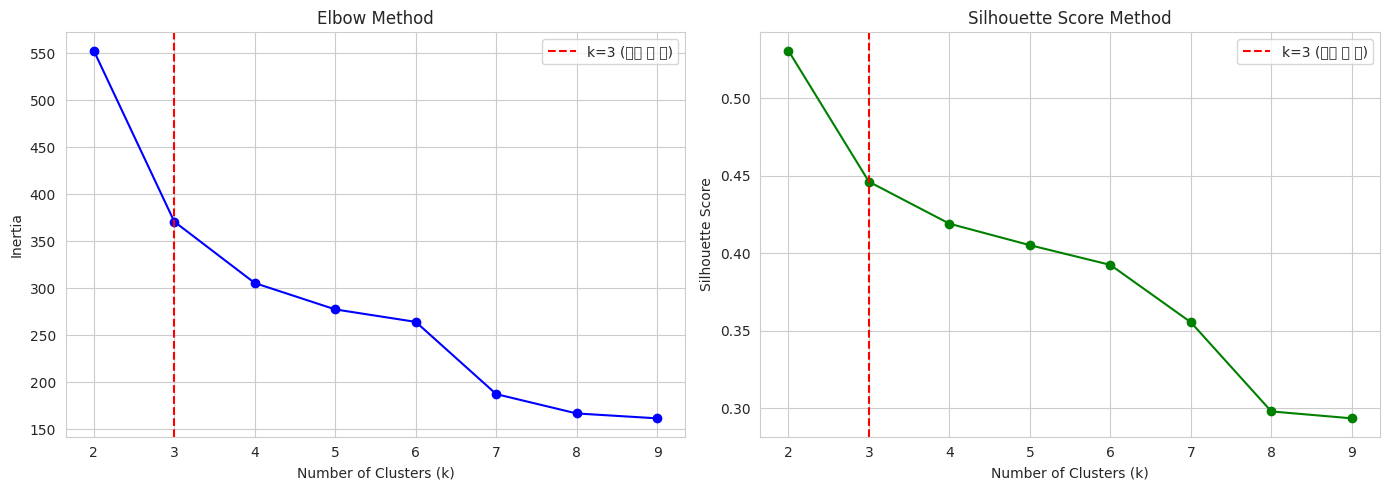

📊 최적 클러스터 수 결정:
  Elbow point: k=3 (실제 펭귄 종 수와 일치!)
  최고 Silhouette Score: k=2


In [24]:
print("🎯 비지도학습: 정답 없이 패턴 찾기\n")

# 클러스터링용 데이터 (정답 제외)
X_cluster = penguins_clean[['bill_length_mm', 'bill_depth_mm',
                            'flipper_length_mm', 'body_mass_g']]
X_cluster_scaled = StandardScaler().fit_transform(X_cluster)

# 최적 클러스터 수 찾기 (Elbow Method)
inertias = []
silhouette_scores = []
K_range = range(2, 10)

from sklearn.metrics import silhouette_score

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster_scaled, kmeans.labels_))

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].axvline(x=3, color='red', linestyle='--', label='k=3 (실제 종 수)')
axes[0].legend()

axes[1].plot(K_range, silhouette_scores, 'go-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score Method')
axes[1].axvline(x=3, color='red', linestyle='--', label='k=3 (실제 종 수)')
axes[1].legend()

plt.tight_layout()
plt.show()

print("📊 최적 클러스터 수 결정:")
print(f"  Elbow point: k=3 (실제 펭귄 종 수와 일치!)")
print(f"  최고 Silhouette Score: k={K_range[np.argmax(silhouette_scores)]}")

In [25]:
# K=3으로 클러스터링
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_cluster_scaled)

# 실제 종과 비교
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

y_true = LabelEncoder().fit_transform(penguins_clean['species'])
ari = adjusted_rand_score(y_true, clusters)
ami = adjusted_mutual_info_score(y_true, clusters)

print(f"🎯 클러스터링 성능:")
print(f"  Adjusted Rand Index: {ari:.3f} (1에 가까울수록 좋음)")
print(f"  Adjusted Mutual Info: {ami:.3f}")
print(f"  Silhouette Score: {silhouette_score(X_cluster_scaled, clusters):.3f}")

# 클러스터 중심
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(cluster_centers, columns=X_cluster.columns)
centers_df['Cluster'] = [f'Cluster {i}' for i in range(3)]

print("\n📍 클러스터 중심점 (원본 스케일):")
print(centers_df.round(1))

🎯 클러스터링 성능:
  Adjusted Rand Index: 0.799 (1에 가까울수록 좋음)
  Adjusted Mutual Info: 0.789
  Silhouette Score: 0.446

📍 클러스터 중심점 (원본 스케일):
   bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g    Cluster
0            38.3           18.2              188.9       3607.4  Cluster 0
1            47.6           15.1              217.6       5115.2  Cluster 1
2            47.7           18.8              197.2       3913.7  Cluster 2


## PCA 차원축소
## 주성분분석

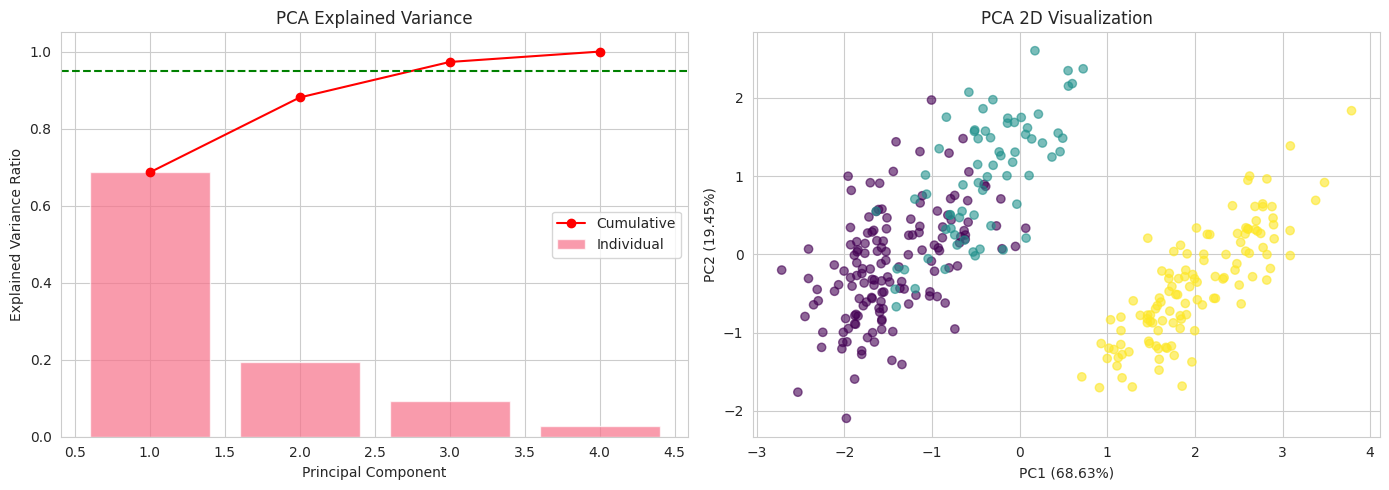

📊 PCA 결과:
  PC1 설명 분산: 68.63%
  PC1+PC2 설명 분산: 88.09%
  95% 분산 설명에 필요한 차원: 3개

🔍 주성분 구성 (loadings):
                     PC1    PC2
bill_length_mm     0.454  0.600
bill_depth_mm     -0.399  0.796
flipper_length_mm  0.577  0.006
body_mass_g        0.550  0.076

해석:
  PC1: 주로 크기 관련 (flipper, body_mass)
  PC2: 주로 부리 모양 관련 (bill dimensions)


In [26]:
from sklearn.decomposition import PCA

# PCA 적용
pca = PCA()
X_pca_all = pca.fit_transform(X_cluster_scaled)

# 설명된 분산 비율
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].bar(range(1, len(explained_variance_ratio) + 1),
            explained_variance_ratio, alpha=0.7, label='Individual')
axes[0].plot(range(1, len(cumulative_variance_ratio) + 1),
            cumulative_variance_ratio, 'ro-', label='Cumulative')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('PCA Explained Variance')
axes[0].legend()
axes[0].axhline(y=0.95, color='g', linestyle='--', label='95%')

# 2D PCA plot
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_cluster_scaled)

axes[1].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
               c=y_true, cmap='viridis', alpha=0.6)
axes[1].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%})')
axes[1].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%})')
axes[1].set_title('PCA 2D Visualization')

plt.tight_layout()
plt.show()

print("📊 PCA 결과:")
print(f"  PC1 설명 분산: {explained_variance_ratio[0]:.2%}")
print(f"  PC1+PC2 설명 분산: {cumulative_variance_ratio[1]:.2%}")
print(f"  95% 분산 설명에 필요한 차원: {np.argmax(cumulative_variance_ratio >= 0.95) + 1}개")

# 주성분 해석
components_df = pd.DataFrame(
    pca_2d.components_.T,
    columns=['PC1', 'PC2'],
    index=X_cluster.columns
)
print("\n🔍 주성분 구성 (loadings):")
print(components_df.round(3))
print("\n해석:")
print("  PC1: 주로 크기 관련 (flipper, body_mass)")
print("  PC2: 주로 부리 모양 관련 (bill dimensions)")